In [4]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from HanTa import HanoverTagger as ht
%matplotlib inline

nltk.download('wordnet')
nltk.download("stopwords")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic Modelling

For topic modelling the same data set as for the sentiment analysis is used, which means that tweets not directly containing the hashtag, as well as retweets are removed. 

In [3]:
df = pd.read_csv ('data/tweets/IchBinHannaUser.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]

In [4]:
df.columns

Index(['author.description', 'author.id', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count', 'author.username', 'author_id',
       'created_at', 'id', 'lang', 'public_metrics.retweet_count', 'text',
       'hashtags', 'reference_type', 'wanted_tag', 'user.group'],
      dtype='object')

In [5]:
#get the correct data
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['processed'] = df['text'].astype(str)
df['processed'] = df['processed'].replace(r'\\n',  ' ', regex=True)

In [6]:
#clean the data (remove URLs, emojis and line breaks)
pat1 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat2 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].astype(str)

In [7]:
#preprocessing (tokenization, stop word removal, lemmatizing)
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
add_stop_all = ["ichbinhanna","#ichbinhanna", "hanna", "mehr", "innen", "#wisszeitvg", "#ichbinhannah", "@amreibahr", "amreibahr", "@bmf_bund","bmf_bund", "@drkeichhorn", "drkeichhorn", "@sebastiankubon", "sebastiankubon", "@bmbf_bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre", "sehen", "ganz","bekommen"]
german_stop.update(set(add_stop_all))
english_stop.update(set(add_stop_all))
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove all words consisting of 3 characters or less to shorten the dictionary of unique words
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in english_stop]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in german_stop]).split(),axis=1)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 3])
lemmatizer = WordNetLemmatizer()
hannover = ht.HanoverTagger('morphmodel_ger.pgz')
df['lemmatized'] = df[['tokenized','lang']].apply(lambda x: [lemmatizer.lemmatize(word).lower() for word in x['tokenized']] if x['lang'] == 'en' else [hannover.analyze(word)[0].lower() for word in x['tokenized']] ,axis=1)

In [8]:
def perform_LDA(tokens, topics=5, passes =5, alpha = 'symmetric', decay = 0.5):
    #create the dictionary of lemmatized tokens
    dic = Dictionary(tokens)
    #print(len(dic))
    #remove low and high frequent terms
    dic.filter_extremes(no_below=2, no_above=.99)
    #print(len(dic))
    #create the bag of words 
    corpus = [dic.doc2bow(d) for d in tokens]
    #build LDA model 
    LDA = LdaMulticore(corpus= corpus, num_topics=topics, id2word= dic, workers=12, passes=passes, alpha = alpha, decay = decay)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA.print_topics()]
    #create topics
    topics = [' '.join(t[0:10]) for t in words]

    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
    # Compute Perplexity
    perplexity = LDA.log_perplexity(corpus)
    print('\nPerplexity: ', perplexity) 
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=LDA, texts=tokens, 
                                   dictionary=dic, coherence='c_v')
    coherence_lda_model = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model)
    return LDA

In [9]:
#perform topic modelling by applying LDA on the whole data set, and on the german/english only sets (guided by: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
#full data set
full_model = perform_LDA(df['tokenized'])

------ Topic 0 ------
forschung @anjakarliczek jahren system lehre heute warum zeit immer deutschland

------ Topic 1 ------
thread jahre jahren system immer forschung innovation einfach #ichbinreyhan @anjakarliczek

------ Topic 2 ------
unis jahre #ichbinreyhan @anjakarliczek @gew_bund arbeit gute gerade müssen dank

------ Topic 3 ------
@anjakarliczek system jahre hashtag eigentlich stelle jahren #ichbinreyhan wisszeitvg lehre

------ Topic 4 ------
#hannaimbundestag gerade arbeit zeit immer system thema hochschulen heute @anjakarliczek


Perplexity:  -9.156520606271062

Coherence Score:  0.19602896604062398


In [10]:
#only german tweets
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]
ger_model = perform_LDA(df_ger['tokenized'])

------ Topic 0 ------
@anjakarliczek hashtag jahren müssen debatte @gew_bund einfach letzten zeit #hannaimbundestag

------ Topic 1 ------
@anjakarliczek #hannaimbundestag jahre system #ichbinreyhan unis stelle forschung promotion arbeit

------ Topic 2 ------
heute forschung warum danke immer eigentlich macht @anjakarliczek statt jahren

------ Topic 3 ------
stellen forschung gerade zeit unis jahre immer arbeit promotion heute

------ Topic 4 ------
immer stelle jahre gerade forschung lehre stellen arbeit @anjakarliczek arbeitsbedingungen


Perplexity:  -8.963152762752816

Coherence Score:  0.1043787376628561


In [11]:
#only english tweets
en_model = perform_LDA(df_en['tokenized'])

------ Topic 0 ------
research scholars without time need contracts still system read precarity

------ Topic 1 ------
contracts many system time would scientists discussion researchers people short

------ Topic 2 ------
precarious conditions working researchers #ichbinreyhan career system research international english

------ Topic 3 ------
system research permanent people years work contract #ichbinreyhan contracts thread

------ Topic 4 ------
thread work years like know good want system @anjakarliczek scholars


Perplexity:  -7.937851686304025

Coherence Score:  0.2323283985036689


In [12]:
#get topics by month
df_june = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-06-30 23:59:59')]
df_july = df.loc[(df['new_date'] > '2021-07-01 00:00:00') & (df['new_date'] <= '2021-07-31 23:59:59')]
df_august = df.loc[(df['new_date'] > '2021-08-01 00:00:00') & (df['new_date'] <= '2021-08-31 23:59:59')]
df_september = df.loc[(df['new_date'] > '2021-09-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [13]:
#tweets from june
june_model = perform_LDA(df_june['tokenized'])

------ Topic 0 ------
#hannaimbundestag @anjakarliczek immer einfach thread danke lehre warum dafür stellen

------ Topic 1 ------
jahre jahren hashtag forschung befristet letzten lehre promotion stellen eigentlich

------ Topic 2 ------
system stelle @anjakarliczek problem stellen immer jahren contracts wurde position

------ Topic 3 ------
#hannaimbundestag heute unis problem @anjakarliczek system #95vswisszeitvg stunde statt zeit

------ Topic 4 ------
#hannaimbundestag @anjakarliczek promotion forschung wisszeitvg gerade arbeit hochschulen wurde dabei


Perplexity:  -8.936641609923134

Coherence Score:  0.23258832139576008


In [14]:
#tweets from july
july_model = perform_LDA(df_july['tokenized'])

------ Topic 0 ------
system #hannabeidergew lehre #ichbinreyhan @gew_bund forschung problem arbeitsbedingungen eigentlich stelle

------ Topic 1 ------
wirklich jahre #ichbinreyhan stellen @anjakarliczek immer thread hochschulen gerade niemand

------ Topic 2 ------
#ichbinreyhan @tagesthemen immer arbeitsbedingungen kommentar unis müssen lehre gerade gute

------ Topic 3 ------
#ichbinreyhan work einfach @gew_bund @anjakarliczek working macht research story heute

------ Topic 4 ------
@anjakarliczek @gew_bund deutschland forschung nachwuchs immer unis danke warum #ichbinreyhan


Perplexity:  -8.721100236241195

Coherence Score:  0.3192485576043561


In [15]:
#tweets from august
august_model = perform_LDA(df_august['tokenized'])

------ Topic 0 ------
#ichbinreyhan beitrag gerade leider leute arbeiten immer studierende thread system

------ Topic 1 ------
#ichbinreyhan immer arbeit aktuellen einfach @karolinedoering @mahaelhissy vielleicht eigentlich sprechen

------ Topic 2 ------
zeit #ichbinreyhan @anjakarliczek kommt immer #frististfrust warum thema fragen frage

------ Topic 3 ------
@anjakarliczek system #waspostdocswollen #dauerstellen warum #ichbinreyhan @gew_bund @heutejournal heute stellen

------ Topic 4 ------
forschung hochschulen immer frage system researchers zeit situation position menschen


Perplexity:  -8.333229439932879

Coherence Score:  0.4236050174113057


In [16]:
#tweets from september
september_model = perform_LDA(df_september['tokenized'])

------ Topic 0 ------
#ichbinreyhan @gew_bund arbeitsbedingungen eigentlich #entfristethanna immer stellen #dauerstellen arbeit bleiben

------ Topic 1 ------
heute stelle gerade forschung hochschulen lehre unis genau postdocs zeit

------ Topic 2 ------
@gew_bund #ichbinreyhan system stellen heute @mahaelhissy lehre danke jahren neue

------ Topic 3 ------
#ichbinreyhan monate #hannainzahlen immer gute @gew_bund müssen jahren aktuellen vertrags

------ Topic 4 ------
#btw21 heute #ichbinreyhan neue @gew_bund berlin macht #hannaorganisiertsich arbeit #r2g


Perplexity:  -8.256793974035975

Coherence Score:  0.3982788122596362


In [17]:
def visualize_topics(tokens):
    #Visualization of topic distance 
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    #create the bag of words 
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    #build LDA model a 
    vis_LDA = LdaMulticore(corpus= vis_corpus, num_topics=5, id2word= vis_dic, workers=12, passes=5, random_state = 1)
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(vis_LDA, vis_corpus, vis_dic)
def visualize_model(model, tokens):
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(model, vis_corpus, vis_dic)

In [18]:
visualize_topics(df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.057406 -0.031338       1        1  23.674601
3      0.041509  0.006472       2        1  21.638669
1     -0.006996 -0.061917       3        1  18.606139
0      0.066338  0.011564       4        1  18.544310
2     -0.043445  0.075219       5        1  17.536281, topic_info=                Term        Freq       Total Category  logprob  loglift
1650          jahren  603.000000  603.000000  Default  30.0000  30.0000
1664         letzten  273.000000  273.000000  Default  29.0000  29.0000
197   @anjakarliczek  902.000000  902.000000  Default  28.0000  28.0000
65            thread  398.000000  398.000000  Default  27.0000  27.0000
1599           jahre  683.000000  683.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
405            heute   85.289920  518.995303   Topic5  -6.1203  -0.0649
867            immer   90.380473  690.805266   Topic5  -6.0623  -0.2929
835           gerade   75.219919  573.584852   Topic5  -6.2459  -0.2906
1690     deutschland   70.519567  388.362122   Topic5  -6.3105   0.0349
1325            unis   68.545130  456.320032   Topic5  -6.3389  -0.1548

[495 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1571      1  0.260532  #95vswisszeitvg
1571      2  0.138951  #95vswisszeitvg
1571      3  0.090318  #95vswisszeitvg
1571      4  0.142424  #95vswisszeitvg
1571      5  0.371693  #95vswisszeitvg
...     ...       ...              ...
4047      5  0.080541            ️ende
4050      1  0.087544      ️stipendium
4050      2  0.787894      ️stipendium
4050      3  0.087544      ️stipendium
4050      5  0.087544      ️stipendium

[1313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [19]:
def create_dic_corpus(tokens):
    dic = Dictionary(tokens)
    dic.filter_extremes(no_below=2, no_above=.99)
    corpus = [dic.doc2bow(d) for d in tokens]
    return dic, corpus
#get optimal number of topics for each (sub)set
def compute_coherence_values_topics(tokens, limit=10, start=2, step=1):
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, random_state = 1)
        model_list_topic.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    print(model_list_topic, coherence_values_topic)
    
def compute_coherence_values_passes(tokens,num_topics):
    
    passes = [5,10,15,20]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_passes = []
    model_list_passes = []
    for num_pass in passes:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = num_pass, random_state = 1)
        model_list_passes.append(num_pass)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_passes.append(coherencemodel.get_coherence())

    print(model_list_passes, coherence_values_passes)
    
def compute_coherence_values_alpha(tokens,num_topics, passes):
    
    alpha = ['symmetric','asymmetric']
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_alpha = []
    model_list_alpha = []
    for a in alpha:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = a, random_state = 1)
        model_list_alpha.append(a)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    print(model_list_alpha, coherence_values_alpha)
    
def compute_coherence_values_decay(tokens,num_topics, passes, alpha):
    
    decay = [0.5,0.7,0.9]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_decay = []
    model_list_decay = []
    for d in decay:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = alpha, random_state = 1, decay =d)
        model_list_decay.append(d)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_decay.append(coherencemodel.get_coherence())

    print(model_list_decay, coherence_values_decay)

In [20]:
#full data
compute_coherence_values_topics(df['tokenized'])
#english data
compute_coherence_values_topics(df_en['tokenized'])
#german data
compute_coherence_values_topics(df_ger['tokenized'])
#june data
compute_coherence_values_topics(df_june['tokenized'])
#july data
compute_coherence_values_topics(df_july['tokenized'])
#august data
compute_coherence_values_topics(df_august['tokenized'])
#september data
compute_coherence_values_topics(df_september['tokenized'])

[2, 3, 4, 5, 6, 7, 8, 9] [0.20724123479308415, 0.14448147382907475, 0.1257679633885763, 0.12417968751444412, 0.12434549641029474, 0.12053637810282873, 0.12053284118709445, 0.13275832083547934]
[2, 3, 4, 5, 6, 7, 8, 9] [0.15872127318363816, 0.19042360868727096, 0.19232521362221944, 0.1782942342540139, 0.19811954951734215, 0.22057608859820052, 0.23112207314892452, 0.24310587320493685]
[2, 3, 4, 5, 6, 7, 8, 9] [0.14905430267919023, 0.1194570446548613, 0.10508421337504459, 0.11628804625250047, 0.12496391611286077, 0.11995792823019658, 0.1222687308026342, 0.12967560010868884]
[2, 3, 4, 5, 6, 7, 8, 9] [0.19627746650085187, 0.15077720270219788, 0.17878527266043734, 0.14748414410889438, 0.2023685490041651, 0.20389371697150396, 0.18867094224611344, 0.18851741272588993]
[2, 3, 4, 5, 6, 7, 8, 9] [0.2718678044645053, 0.3227806572504709, 0.33341964020152204, 0.31513115914356327, 0.3137663993811249, 0.3172137196788887, 0.34619266611987265, 0.3582727662739486]
[2, 3, 4, 5, 6, 7, 8, 9] [0.441388559102

In [21]:
#full data
compute_coherence_values_passes(df['tokenized'], 6)
#english data
compute_coherence_values_passes(df_en['tokenized'],7)
#german data
compute_coherence_values_passes(df_ger['tokenized'],8)
#june data
compute_coherence_values_passes(df_june['tokenized'],7)
#july data
compute_coherence_values_passes(df_july['tokenized'],7)
#august data
compute_coherence_values_passes(df_august['tokenized'],7)
#september data
compute_coherence_values_passes(df_september['tokenized'],6)

[5, 10, 15, 20] [0.19744003721951386, 0.19898493735489634, 0.25445039696689675, 0.2646541988765015]
[5, 10, 15, 20] [0.23652599927539747, 0.2372808662198025, 0.2391021912287965, 0.2355887868609557]
[5, 10, 15, 20] [0.14499457901403184, 0.18297151361170405, 0.19933684736842827, 0.2140738439585241]
[5, 10, 15, 20] [0.1889715818594237, 0.22328815252155967, 0.22944199248023422, 0.24864414505571747]
[5, 10, 15, 20] [0.32488283320194006, 0.36579828525289276, 0.3565916222980972, 0.34564263174998133]
[5, 10, 15, 20] [0.38716670470480663, 0.4019267073565121, 0.39785400748485866, 0.4104051650525607]
[5, 10, 15, 20] [0.3815216388916145, 0.38164615172150335, 0.3779828879515213, 0.3742828207688374]


In [22]:
#full data
compute_coherence_values_alpha(df['tokenized'], 6,20)
#english data
compute_coherence_values_alpha(df_en['tokenized'],7,20)
#german data
compute_coherence_values_alpha(df_ger['tokenized'],8,20)
#june data
compute_coherence_values_alpha(df_june['tokenized'],7,20)
#july data
compute_coherence_values_alpha(df_july['tokenized'],7,15)
#august data
compute_coherence_values_alpha(df_august['tokenized'],7,20)
#september data
compute_coherence_values_alpha(df_september['tokenized'],6,20)

['symmetric', 'asymmetric'] [0.26654500679409826, 0.2939875265405616]
['symmetric', 'asymmetric'] [0.2355887868609557, 0.28983941056029866]
['symmetric', 'asymmetric'] [0.212972773045547, 0.23825544738130516]
['symmetric', 'asymmetric'] [0.25260984576622253, 0.3551642057758653]
['symmetric', 'asymmetric'] [0.3565916222980972, 0.3702861438823315]
['symmetric', 'asymmetric'] [0.4104051650525607, 0.43244752279392706]
['symmetric', 'asymmetric'] [0.3742828207688374, 0.5454697500370588]


In [23]:
#full data
compute_coherence_values_decay(df['tokenized'], 6,20,'asymmetric')
#english data
compute_coherence_values_decay(df_en['tokenized'],7,20,'symmetric')
#german data
compute_coherence_values_decay(df_ger['tokenized'],8,20,'symmetric')
#june data
compute_coherence_values_decay(df_june['tokenized'],7,20,'asymmetric')
#july data
compute_coherence_values_decay(df_july['tokenized'],7,20,'asymmetric')
#august data
compute_coherence_values_decay(df_august['tokenized'],7,20,'asymmetric')
#september data
compute_coherence_values_decay(df_september['tokenized'],6,5,'symmetric')

[0.5, 0.7, 0.9] [0.2939875265405616, 0.2838974825313411, 0.22218887650814254]
[0.5, 0.7, 0.9] [0.2355887868609557, 0.23721491714829096, 0.24150878301389936]
[0.5, 0.7, 0.9] [0.21841753026638827, 0.18808780611779413, 0.1511526249727578]
[0.5, 0.7, 0.9] [0.3605675165154551, 0.3103810935104527, 0.24353233632524923]
[0.5, 0.7, 0.9] [0.34438475471875585, 0.3792955333717977, 0.3742203087340466]
[0.5, 0.7, 0.9] [0.43244752279392706, 0.42360111396249894, 0.420523596028651]
[0.5, 0.7, 0.9] [0.3815216388916145, 0.3842196613348565, 0.3825162828336612]


In [24]:
#get the optimal models
print('Topics for the whole model')
optimal_full = perform_LDA(df['tokenized'],6,20,'asymmetric',0.5)
print('Topics for the English model')
optimal_en = perform_LDA(df_en['tokenized'],7,20,'symmetric',0.5)
print('Topics for the German model')
optimal_ger = perform_LDA(df_ger['tokenized'],8,20,'symmetric',0.5)
print('Topics for the June model')
optimal_june = perform_LDA(df_june['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the July model')
optimal_july = perform_LDA(df_july['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the August model')
optimal_august = perform_LDA(df_august['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the September model')
optimal_september = perform_LDA(df_september['tokenized'],6,5,'asymmetric',0.9)

Topics for the whole model
------ Topic 0 ------
@anjakarliczek #hannaimbundestag immer stellen forschung #ichbinreyhan jahre gerade heute lehre

------ Topic 1 ------
promotion jahre jahren stelle warum zeit vertrag eigentlich forschung deutschland

------ Topic 2 ------
system research years work contracts many working researchers conditions career

------ Topic 3 ------
heute thema diskussion sprechen bmbf folge dafür danke @anjakarliczek gute

------ Topic 4 ------
lehre system forschung professur stellen vielleicht unis @s_mittermeier mittelbau wurde

------ Topic 5 ------
problem system @anjakarliczek forschung immer karriere wohl lehre einfach heute


Perplexity:  -8.926226297532944

Coherence Score:  0.3254160674406155
Topics for the English model
------ Topic 0 ------
system researchers contracts even science many discussion conditions career great

------ Topic 1 ------
@mahaelhissy thread movement scholars work much @kinofrau1 thank working like

------ Topic 2 ------
#ichbi

In [25]:
visualize_model(optimal_full, df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.113354  0.018454       1        1  51.309878
1      0.102232  0.029306       2        1  20.172642
2     -0.334495  0.009114       3        1  13.050286
4      0.041884  0.093321       4        1   5.985760
3      0.039493 -0.158534       5        1   5.362461
5      0.037531  0.008338       6        1   4.118973, topic_info=           Term        Freq       Total Category  logprob  loglift
977       lehre  522.000000  522.000000  Default  30.0000  30.0000
101      system  778.000000  778.000000  Default  29.0000  29.0000
1037  forschung  712.000000  712.000000  Default  28.0000  28.0000
405       heute  519.000000  519.000000  Default  27.0000  27.0000
624    research  184.000000  184.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1079      kommt   15.407699  262.275784   Topic6  -6.3828   0.3550
65       thread   15.721099  402.514225   Topic6  -6.3627  -0.0532
2199   menschen   15.317177  392.511093   Topic6  -6.3887  -0.0540
1039       gute   15.159994  390.645285   Topic6  -6.3990  -0.0596
820      arbeit   14.885164  495.487575   Topic6  -6.4173  -0.3156

[461 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
1354      1  0.577882  #acertaindegreeofflexibility
1354      2  0.165109  #acertaindegreeofflexibility
1354      3  0.105486  #acertaindegreeofflexibility
1354      4  0.032105  #acertaindegreeofflexibility
1354      5  0.114659  #acertaindegreeofflexibility
...     ...       ...                           ...
4046      5  0.943654              ️arbeitsverträge
4047      5  0.906838                         ️ende
4048      5  0.941851      ️erwerbsarbeitslosigkeit
4049      5  0.915794                       ️kinder
4050      5  0.884022                   ️stipendium

[1154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6])

In [26]:
visualize_model(optimal_en, df_en['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.025195 -0.081532       1        1  16.108943
0      0.032746  0.015651       2        1  15.352888
5      0.018785 -0.083529       3        1  15.084340
3      0.107088  0.095826       4        1  14.868761
2     -0.020446  0.080732       5        1  14.205238
1     -0.163864  0.038311       6        1  14.185435
6      0.050886 -0.065459       7        1  10.194396, topic_info=              Term        Freq       Total Category  logprob  loglift
51          thread  141.000000  141.000000  Default  30.0000  30.0000
24   #ichbinreyhan  111.000000  111.000000  Default  29.0000  29.0000
259          years  161.000000  161.000000  Default  28.0000  28.0000
40    @mahaelhissy   72.000000   72.000000  Default  27.0000  27.0000
116     conditions  127.000000  127.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
234        problem    9.045088   59.619179   Topic7  -5.7925   0.3976
257        postdoc    8.673447   46.316312   Topic7  -5.8344   0.6081
22       permanent    9.230822  108.232779   Topic7  -5.7721  -0.1784
233      positions    8.796097   69.743194   Topic7  -5.8204   0.2128
6             time    9.052012  123.403423   Topic7  -5.7917  -0.3291

[558 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
224       2  0.839699         #academic
1465      2  0.766393  #academictwitter
1465      3  0.159665  #academictwitter
1465      4  0.031933  #academictwitter
1465      5  0.031933  #academictwitter
...     ...       ...               ...
259       3  0.068292             years
259       4  0.540128             years
259       5  0.149001             years
259       6  0.018625             years
259       7  0.080709             years

[1280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 4, 3, 2, 7])

In [27]:
visualize_model(optimal_ger, df_ger['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.027421  0.044950       1        1  13.733310
6      0.018649 -0.005936       2        1  13.673405
0      0.053268  0.034611       3        1  12.988407
7     -0.022794  0.017458       4        1  12.737380
2     -0.143860  0.051080       5        1  12.602636
4      0.075089  0.011148       6        1  12.239714
3     -0.025152 -0.155370       7        1  11.139998
5      0.017380  0.002059       8        1  10.885149, topic_info=                   Term        Freq       Total Category  logprob  loglift
2605          @gew_bund  411.000000  411.000000  Default  30.0000  30.0000
4036            stunden  121.000000  121.000000  Default  29.0000  29.0000
17            wichtiger  140.000000  140.000000  Default  28.0000  28.0000
1131     @anjakarliczek  838.000000  838.000000  Default  27.0000  27.0000
470   #hannaimbundestag  633.000000  633.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
560           promotion   48.338883  498.202376   Topic8  -6.0621  -0.1150
226          eigentlich   44.855202  426.909524   Topic8  -6.1369  -0.0354
502            übrigens   39.071243  202.460429   Topic8  -6.2749   0.5726
665             stellen   46.715110  577.830977   Topic8  -6.0963  -0.2974
90                hätte   39.696679  250.792188   Topic8  -6.2591   0.3744

[687 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
733       1  0.252944           #95vswisszeitvg
733       2  0.241269           #95vswisszeitvg
733       3  0.027240           #95vswisszeitvg
733       4  0.140092           #95vswisszeitvg
733       5  0.124526           #95vswisszeitvg
...     ...       ...                       ...
2744      6  0.936986          ️arbeitsverträge
2745      6  0.914865                     ️ende
2746      6  0.865013  ️erwerbsarbeitslosigkeit
2747      6  0.841072                   ️kinder
2748      6  0.901008               ️stipendium

[2078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 8, 3, 5, 4, 6])

In [28]:
visualize_model(optimal_june, df_june['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.112646  0.021648       1        1  42.020504
1     -0.109063  0.025808       2        1  24.050288
2      0.324833  0.067405       3        1  11.217812
3     -0.082536  0.067594       4        1   8.903887
5     -0.061113  0.052561       5        1   5.627012
4     -0.016877 -0.075924       6        1   4.754671
6      0.057404 -0.159091       7        1   3.425827, topic_info=                   Term        Freq       Total Category  logprob  loglift
64    #hannaimbundestag  660.000000  660.000000  Default  30.0000  30.0000
72               system  495.000000  495.000000  Default  29.0000  29.0000
854              stelle  330.000000  330.000000  Default  28.0000  28.0000
870               heute  287.000000  287.000000  Default  27.0000  27.0000
375               jahre  522.000000  522.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
903           situation    8.444106  154.597734   Topic7  -6.2267   0.4665
916        akademischen    7.669522   86.399274   Topic7  -6.3229   0.9521
5242               stay    6.610159   32.691117   Topic7  -6.4715   1.7753
1247              immer    8.045942  395.777807   Topic7  -6.2750  -0.5219
943         bedingungen    6.793083  102.724551   Topic7  -6.4442   0.6577

[514 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
331       1  0.292194  #95vswisszeitvg
331       2  0.382875  #95vswisszeitvg
331       3  0.151135  #95vswisszeitvg
331       4  0.065492  #95vswisszeitvg
331       5  0.055416  #95vswisszeitvg
...     ...       ...              ...
5504      5  0.911016           zwingt
1136      1  0.972795       österreich
1136      4  0.029479       österreich
6537      2  0.961534        überhöhte
1749      2  0.854919     überlegungen

[1243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 6, 5, 7])

In [29]:
visualize_model(optimal_july, df_july['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.103128  0.016507       1        1  37.428014
1     -0.247960  0.029633       2        1  20.397208
2      0.118652  0.023989       3        1  16.132106
3     -0.057595 -0.030444       4        1   7.514815
4      0.016979 -0.145762       5        1   6.889505
5      0.033249  0.126820       6        1   6.062999
6      0.033546 -0.020743       7        1   5.575353, topic_info=               Term        Freq       Total Category  logprob  loglift
24    #ichbinreyhan  239.000000  239.000000  Default  30.0000  30.0000
515           immer  146.000000  146.000000  Default  29.0000  29.0000
1104       menschen   74.000000   74.000000  Default  28.0000  28.0000
525          müssen   86.000000   86.000000  Default  27.0000  27.0000
952         hashtag   36.000000   36.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
612           lehre    7.372066  114.449657   Topic7  -5.8119   0.1444
24    #ichbinreyhan    7.063087  239.277547   Topic7  -5.8547  -0.6359
706          medien    5.464961   21.244459   Topic7  -6.1112   1.5291
1898         jahren    6.209912   92.115930   Topic7  -5.9834   0.1899
1583   @bjoern_krey    5.441622   21.781609   Topic7  -6.1155   1.4998

[522 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2299      2  0.930790  #academictwitter
6582      7  0.654413      #altenpflege
79        1  0.847371     #dauerstellen
79        2  0.102269     #dauerstellen
79        5  0.043830     #dauerstellen
...     ...       ...               ...
1231      6  0.247756            ändern
2079      4  0.621384  österreichischen
630       1  0.124661         überleben
630       5  0.747968         überleben
5018      5  0.630460        überstunde

[1104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [30]:
visualize_model(optimal_august, df_august['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.039357  0.010905       1        1  39.818879
1      0.034634  0.106071       2        1  20.600322
2      0.055160 -0.028771       3        1  13.113929
3      0.040811 -0.146927       4        1   9.326095
4     -0.191541 -0.008012       5        1   7.141948
5      0.036648  0.057065       6        1   5.913560
6     -0.015069  0.009670       7        1   4.085267, topic_info=               Term        Freq       Total Category  logprob  loglift
202         beitrag   34.000000   34.000000  Default  30.0000  30.0000
269       aktuellen   27.000000   27.000000  Default  29.0000  29.0000
1626  #dauerstellen   43.000000   43.000000  Default  28.0000  28.0000
690            jahn   23.000000   23.000000  Default  27.0000  27.0000
15    #ichbinreyhan  138.000000  138.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
198     hochschulen    2.179514   41.389795   Topic7  -5.8769   0.2539
261     bedingungen    2.142252   24.051693   Topic7  -5.8942   0.7794
320        arbeiten    2.154296   45.540289   Topic7  -5.8886   0.1466
461      diskussion    2.116471   24.289752   Topic7  -5.9063   0.7575
133          online    2.022127   10.972254   Topic7  -5.9519   1.5066

[481 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1008      2  0.086384  #95wisspausen
1008      3  0.604685  #95wisspausen
1008      4  0.345534  #95wisspausen
3544      2  0.871789      #afghanen
1637      1  0.151107         #bafög
...     ...       ...            ...
308       5  0.098370         ändern
308       7  0.049185         ändern
468       5  0.913211        überall
468       7  0.083019        überall
1641      3  0.904049           💁🏻‍♂

[980 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [31]:
visualize_model(optimal_september, df_september['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030510 -0.010686       1        1  46.109294
1     -0.005950  0.061082       2        1  21.043913
2     -0.032322 -0.030878       3        1  12.472795
3      0.164616 -0.018564       4        1   8.123615
4     -0.058451 -0.097765       5        1   7.087450
5     -0.037383  0.096812       6        1   5.162934, topic_info=              Term        Freq       Total Category  logprob  loglift
51   #ichbinreyhan  138.000000  138.000000  Default  30.0000  30.0000
166      @gew_bund   92.000000   92.000000  Default  29.0000  29.0000
460         müssen   39.000000   39.000000  Default  28.0000  28.0000
152     eigentlich   36.000000   36.000000  Default  27.0000  27.0000
723  #dauerstellen   43.000000   43.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
429        bleiben    2.135479   15.730936   Topic6  -6.0128   0.9667
96          vielen    2.114061   24.164852   Topic6  -6.0229   0.5274
272      forschung    2.186315   47.034443   Topic6  -5.9893  -0.1050
79         endlich    2.089682   20.614482   Topic6  -6.0345   0.6747
483          davon    2.087755   26.390636   Topic6  -6.0354   0.4267

[419 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
333       1  0.746511  #95vswisszeitvg
333       2  0.037326  #95vswisszeitvg
333       3  0.149302  #95vswisszeitvg
333       4  0.037326  #95vswisszeitvg
1633      2  0.882155    #95wisspausen
...     ...       ...              ...
684       6  0.704792           ️rente
447       1  0.100886      ️stipendium
447       2  0.605319      ️stipendium
447       4  0.100886      ️stipendium
447       6  0.100886      ️stipendium

[875 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

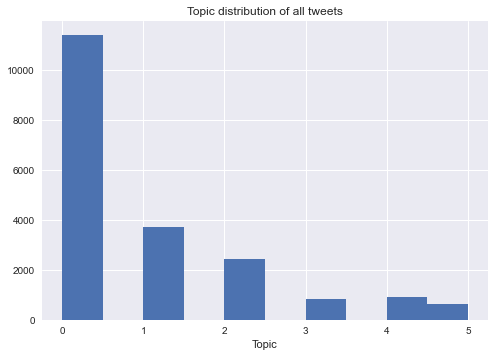

In [32]:
#explicitly get topic distribution (to get total number of tweets per topic)
def get_top_topic(distribution):
    top_topic = 0
    top_prob = 0 
    for topic in distribution:
        if topic[1] > top_prob:
            top_topic = topic[0]
            top_prob = topic[1] 
    return top_topic
#get topic probabilities for all tweets
plt.style.use('seaborn')
full_dic, full_corpus = create_dic_corpus(df['tokenized'])
df['topic distribution'] = df['tokenized'].apply(lambda x: optimal_full.get_document_topics(full_dic.doc2bow(x)))
df['topic'] = df['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df['topic'].hist()
plt.title('Topic distribution of all tweets')
plt.xlabel('Topic')
plt.savefig('topic_hist.pdf')
plt.show()

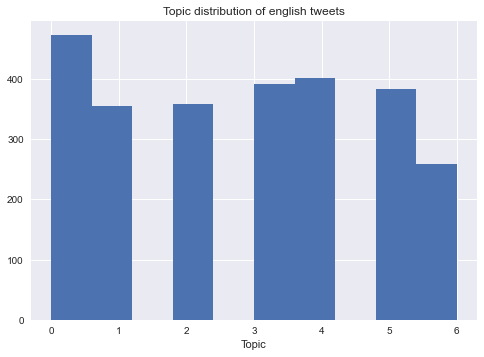

In [33]:
#get topic probabilities for all tweets
en_dic, en_corpus = create_dic_corpus(df_en['tokenized'])
df_en['topic distribution'] = df_en['tokenized'].apply(lambda x: optimal_en.get_document_topics(en_dic.doc2bow(x)))
df_en['topic'] = df_en['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_en['topic'].hist()
plt.title('Topic distribution of english tweets')
plt.xlabel('Topic')
plt.show()

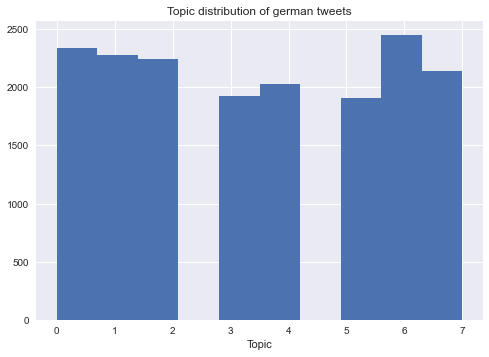

In [34]:
#get topic probabilities for all tweets
ger_dic, ger_corpus = create_dic_corpus(df_ger['tokenized'])
df_ger['topic distribution'] = df_ger['tokenized'].apply(lambda x: optimal_ger.get_document_topics(ger_dic.doc2bow(x)))
df_ger['topic'] = df_ger['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_ger['topic'].hist()
plt.title('Topic distribution of german tweets')
plt.xlabel('Topic')
plt.show()

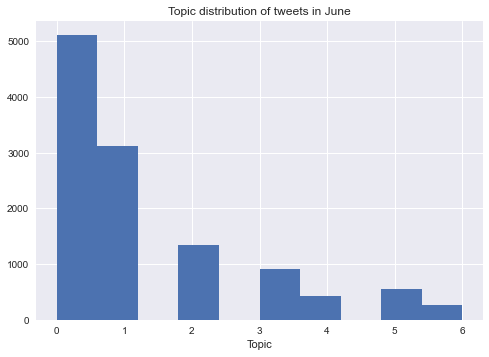

In [35]:
#get topic probabilities for all tweets
june_dic, june_corpus = create_dic_corpus(df_june['tokenized'])
df_june['topic distribution'] = df_june['tokenized'].apply(lambda x: optimal_june.get_document_topics(june_dic.doc2bow(x)))
df_june['topic'] = df_june['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_june['topic'].hist()
plt.title('Topic distribution of tweets in June')
plt.xlabel('Topic')
plt.show()

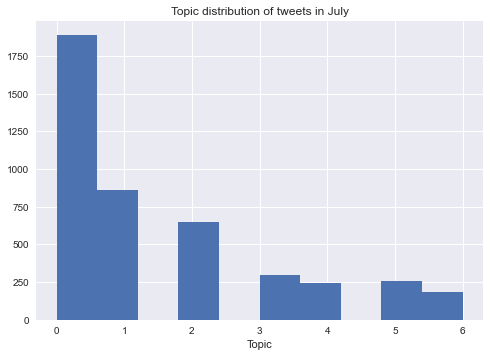

In [36]:
#get topic probabilities for all tweets
july_dic, july_corpus = create_dic_corpus(df_july['tokenized'])
df_july['topic distribution'] = df_july['tokenized'].apply(lambda x: optimal_july.get_document_topics(july_dic.doc2bow(x)))
df_july['topic'] = df_july['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_july['topic'].hist()
plt.title('Topic distribution of tweets in July')
plt.xlabel('Topic')
plt.show()

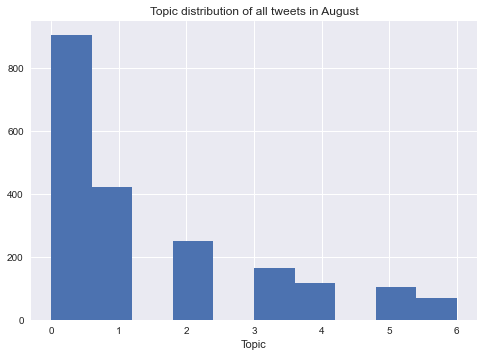

In [37]:
#get topic probabilities for all tweets
august_dic, august_corpus = create_dic_corpus(df_august['tokenized'])
df_august['topic distribution'] = df_august['tokenized'].apply(lambda x: optimal_august.get_document_topics(august_dic.doc2bow(x)))
df_august['topic'] = df_august['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_august['topic'].hist()
plt.title('Topic distribution of all tweets in August')
plt.xlabel('Topic')
plt.show()

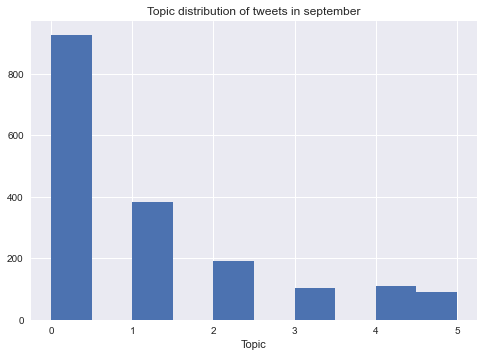

In [38]:
#get topic probabilities for all tweets
september_dic, september_corpus = create_dic_corpus(df_september['tokenized'])
df_september['topic distribution'] = df_september['tokenized'].apply(lambda x: optimal_september.get_document_topics(september_dic.doc2bow(x)))
df_september['topic'] = df_september['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_september['topic'].hist()
plt.title('Topic distribution of tweets in september')
plt.xlabel('Topic')
plt.show()

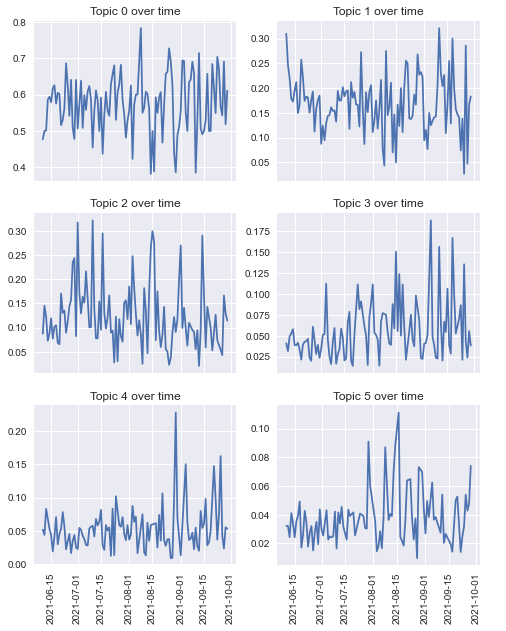

In [39]:
#show the development of tweet frequency of topics over time for the whole set; not particularly insightful for full data
df_topic0 = df.loc[df['topic'] == 0]
df_topic1 = df.loc[df['topic'] == 1]
df_topic2 = df.loc[df['topic'] == 2]
df_topic3 = df.loc[df['topic'] == 3]
df_topic4 = df.loc[df['topic'] == 4]
df_topic5 = df.loc[df['topic'] == 5]
#divide number of tweets of a topic at a day by the total number of topics on that day, to lessen the effect of days with a high tweet frequency
df_freqs = pd.DataFrame(pd.to_datetime(df['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = pd.DataFrame(pd.to_datetime(df_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = df_topic0.merge(df_freqs, on ='index')
df_topic0['count'] = df_topic0['new_date_x']/df_topic0['new_date_y'] 
df_topic1 = pd.DataFrame(pd.to_datetime(df_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic1 = df_topic1.merge(df_freqs, on ='index')
df_topic1['count'] = df_topic1['new_date_x']/df_topic1['new_date_y'] 
df_topic2 = pd.DataFrame(pd.to_datetime(df_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic2 = df_topic2.merge(df_freqs, on ='index')
df_topic2['count'] = df_topic2['new_date_x']/df_topic2['new_date_y'] 
df_topic3 = pd.DataFrame(pd.to_datetime(df_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic3 = df_topic3.merge(df_freqs, on ='index')
df_topic3['count'] = df_topic3['new_date_x']/df_topic3['new_date_y'] 
df_topic4 = pd.DataFrame(pd.to_datetime(df_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic4 = df_topic4.merge(df_freqs, on ='index')
df_topic4['count'] = df_topic4['new_date_x']/df_topic4['new_date_y'] 
df_topic5 = pd.DataFrame(pd.to_datetime(df_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic5 = df_topic5.merge(df_freqs, on ='index')
df_topic5['count'] = df_topic5['new_date_x']/df_topic5['new_date_y']
plt.subplot(3, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_topic0['index'], df_topic0['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_topic1['index'], df_topic1['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_topic2['index'], df_topic2['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_topic3['index'], df_topic3['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_topic4['index'], df_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(3, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_topic5['index'], df_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

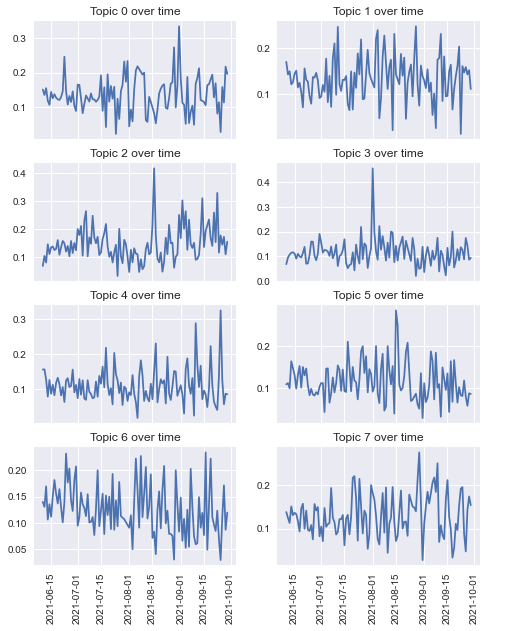

In [40]:
#show the development of tweet frequency of topics over time for the german tweets
df_ger_topic0 = df_ger.loc[df_ger['topic'] == 0]
df_ger_topic1 = df_ger.loc[df_ger['topic'] == 1]
df_ger_topic2 = df_ger.loc[df_ger['topic'] == 2]
df_ger_topic3 = df_ger.loc[df_ger['topic'] == 3]
df_ger_topic4 = df_ger.loc[df_ger['topic'] == 4]
df_ger_topic5 = df_ger.loc[df_ger['topic'] == 5]
df_ger_topic6 = df_ger.loc[df_ger['topic'] == 6]
df_ger_topic7 = df_ger.loc[df_ger['topic'] == 7]
df_ger_freqs = pd.DataFrame(pd.to_datetime(df_ger['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = pd.DataFrame(pd.to_datetime(df_ger_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = df_ger_topic0.merge(df_ger_freqs, on ='index')
df_ger_topic0['count'] = df_ger_topic0['new_date_x']/df_ger_topic0['new_date_y'] 
df_ger_topic1 = pd.DataFrame(pd.to_datetime(df_ger_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic1 = df_ger_topic1.merge(df_ger_freqs, on ='index')
df_ger_topic1['count'] = df_ger_topic1['new_date_x']/df_ger_topic1['new_date_y'] 
df_ger_topic2 = pd.DataFrame(pd.to_datetime(df_ger_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic2 = df_ger_topic2.merge(df_ger_freqs, on ='index')
df_ger_topic2['count'] = df_ger_topic2['new_date_x']/df_ger_topic2['new_date_y'] 
df_ger_topic3 = pd.DataFrame(pd.to_datetime(df_ger_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic3 = df_ger_topic3.merge(df_ger_freqs, on ='index')
df_ger_topic3['count'] = df_ger_topic3['new_date_x']/df_ger_topic3['new_date_y'] 
df_ger_topic4 = pd.DataFrame(pd.to_datetime(df_ger_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic4 = df_ger_topic4.merge(df_ger_freqs, on ='index')
df_ger_topic4['count'] = df_ger_topic4['new_date_x']/df_ger_topic4['new_date_y'] 
df_ger_topic5 = pd.DataFrame(pd.to_datetime(df_ger_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic5 = df_ger_topic5.merge(df_ger_freqs, on ='index')
df_ger_topic5['count'] = df_ger_topic5['new_date_x']/df_ger_topic5['new_date_y']
df_ger_topic6 = pd.DataFrame(pd.to_datetime(df_ger_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic6 = df_ger_topic6.merge(df_ger_freqs, on ='index')
df_ger_topic6['count'] = df_ger_topic6['new_date_x']/df_ger_topic6['new_date_y'] 
df_ger_topic7 = pd.DataFrame(pd.to_datetime(df_ger_topic7['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic7 = df_ger_topic7.merge(df_ger_freqs, on ='index')
df_ger_topic7['count'] = df_ger_topic7['new_date_x']/df_ger_topic7['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_ger_topic0['index'], df_ger_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_ger_topic1['index'], df_ger_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_ger_topic2['index'], df_ger_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_ger_topic3['index'], df_ger_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_ger_topic4['index'], df_ger_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_ger_topic5['index'], df_ger_topic5['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_ger_topic6['index'], df_ger_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 8)
plt.title('Topic 7 over time')
plt.plot(df_ger_topic7['index'], df_ger_topic7['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

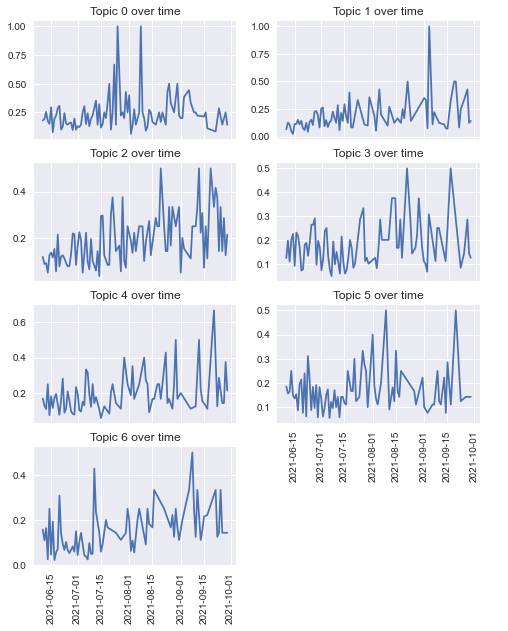

In [41]:
#show the development of tweet frequency of topics over time for the english tweets
df_en_topic0 = df_en.loc[df_en['topic'] == 0]
df_en_topic1 = df_en.loc[df_en['topic'] == 1]
df_en_topic2 = df_en.loc[df_en['topic'] == 2]
df_en_topic3 = df_en.loc[df_en['topic'] == 3]
df_en_topic4 = df_en.loc[df_en['topic'] == 4]
df_en_topic5 = df_en.loc[df_en['topic'] == 5]
df_en_topic6 = df_en.loc[df_en['topic'] == 6]
df_en_freqs = pd.DataFrame(pd.to_datetime(df_en['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = pd.DataFrame(pd.to_datetime(df_en_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = df_en_topic0.merge(df_en_freqs, on ='index')
df_en_topic0['count'] = df_en_topic0['new_date_x']/df_en_topic0['new_date_y'] 
df_en_topic1 = pd.DataFrame(pd.to_datetime(df_en_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic1 = df_en_topic1.merge(df_en_freqs, on ='index')
df_en_topic1['count'] = df_en_topic1['new_date_x']/df_en_topic1['new_date_y'] 
df_en_topic2 = pd.DataFrame(pd.to_datetime(df_en_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic2 = df_en_topic2.merge(df_en_freqs, on ='index')
df_en_topic2['count'] = df_en_topic2['new_date_x']/df_en_topic2['new_date_y'] 
df_en_topic3 = pd.DataFrame(pd.to_datetime(df_en_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic3 = df_en_topic3.merge(df_en_freqs, on ='index')
df_en_topic3['count'] = df_en_topic3['new_date_x']/df_en_topic3['new_date_y'] 
df_en_topic4 = pd.DataFrame(pd.to_datetime(df_en_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic4 = df_en_topic4.merge(df_en_freqs, on ='index')
df_en_topic4['count'] = df_en_topic4['new_date_x']/df_en_topic4['new_date_y'] 
df_en_topic5 = pd.DataFrame(pd.to_datetime(df_en_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic5 = df_en_topic5.merge(df_en_freqs, on ='index')
df_en_topic5['count'] = df_en_topic5['new_date_x']/df_en_topic5['new_date_y']
df_en_topic6 = pd.DataFrame(pd.to_datetime(df_en_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic6 = df_en_topic6.merge(df_en_freqs, on ='index')
df_en_topic6['count'] = df_en_topic6['new_date_x']/df_en_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_en_topic0['index'], df_en_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_en_topic1['index'], df_en_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_en_topic2['index'], df_en_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_en_topic3['index'], df_en_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_en_topic4['index'], df_en_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_en_topic5['index'], df_en_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_en_topic6['index'], df_en_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

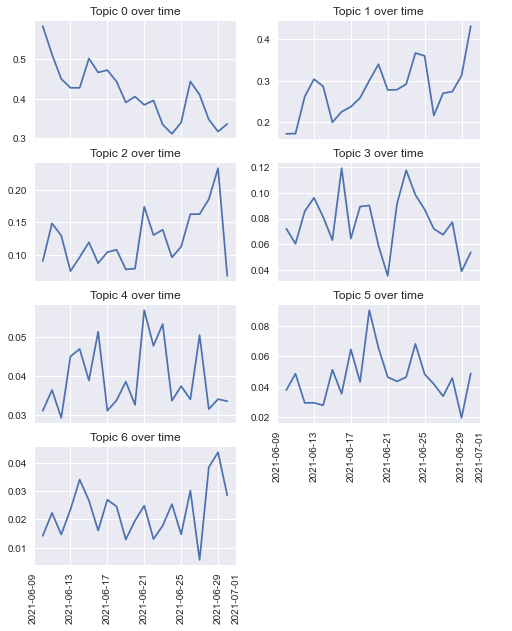

In [42]:
#show the development of tweet frequency of topics over time for the tweets in june
df_june_topic0 = df_june.loc[df_june['topic'] == 0]
df_june_topic1 = df_june.loc[df_june['topic'] == 1]
df_june_topic2 = df_june.loc[df_june['topic'] == 2]
df_june_topic3 = df_june.loc[df_june['topic'] == 3]
df_june_topic4 = df_june.loc[df_june['topic'] == 4]
df_june_topic5 = df_june.loc[df_june['topic'] == 5]
df_june_topic6 = df_june.loc[df_june['topic'] == 6]
df_june_freqs = pd.DataFrame(pd.to_datetime(df_june['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = pd.DataFrame(pd.to_datetime(df_june_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = df_june_topic0.merge(df_june_freqs, on ='index')
df_june_topic0['count'] = df_june_topic0['new_date_x']/df_june_topic0['new_date_y'] 
df_june_topic1 = pd.DataFrame(pd.to_datetime(df_june_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic1 = df_june_topic1.merge(df_june_freqs, on ='index')
df_june_topic1['count'] = df_june_topic1['new_date_x']/df_june_topic1['new_date_y'] 
df_june_topic2 = pd.DataFrame(pd.to_datetime(df_june_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic2 = df_june_topic2.merge(df_june_freqs, on ='index')
df_june_topic2['count'] = df_june_topic2['new_date_x']/df_june_topic2['new_date_y'] 
df_june_topic3 = pd.DataFrame(pd.to_datetime(df_june_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic3 = df_june_topic3.merge(df_june_freqs, on ='index')
df_june_topic3['count'] = df_june_topic3['new_date_x']/df_june_topic3['new_date_y'] 
df_june_topic4 = pd.DataFrame(pd.to_datetime(df_june_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic4 = df_june_topic4.merge(df_june_freqs, on ='index')
df_june_topic4['count'] = df_june_topic4['new_date_x']/df_june_topic4['new_date_y'] 
df_june_topic5 = pd.DataFrame(pd.to_datetime(df_june_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic5 = df_june_topic5.merge(df_june_freqs, on ='index')
df_june_topic5['count'] = df_june_topic5['new_date_x']/df_june_topic5['new_date_y']
df_june_topic6 = pd.DataFrame(pd.to_datetime(df_june_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic6 = df_june_topic6.merge(df_june_freqs, on ='index')
df_june_topic6['count'] = df_june_topic6['new_date_x']/df_june_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_june_topic0['index'], df_june_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_june_topic1['index'], df_june_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_june_topic2['index'], df_june_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_june_topic3['index'], df_june_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_june_topic4['index'], df_june_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_june_topic5['index'], df_june_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_june_topic6['index'], df_june_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

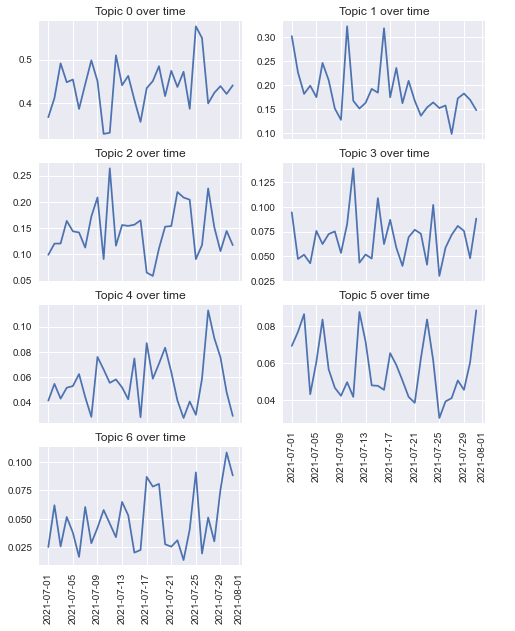

In [43]:
#show the development of tweet frequency of topics over time for the tweets in july
df_july_topic0 = df_july.loc[df_july['topic'] == 0]
df_july_topic1 = df_july.loc[df_july['topic'] == 1]
df_july_topic2 = df_july.loc[df_july['topic'] == 2]
df_july_topic3 = df_july.loc[df_july['topic'] == 3]
df_july_topic4 = df_july.loc[df_july['topic'] == 4]
df_july_topic5 = df_july.loc[df_july['topic'] == 5]
df_july_topic6 = df_july.loc[df_july['topic'] == 6]
df_july_freqs = pd.DataFrame(pd.to_datetime(df_july['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = pd.DataFrame(pd.to_datetime(df_july_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = df_july_topic0.merge(df_july_freqs, on ='index')
df_july_topic0['count'] = df_july_topic0['new_date_x']/df_july_topic0['new_date_y'] 
df_july_topic1 = pd.DataFrame(pd.to_datetime(df_july_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic1 = df_july_topic1.merge(df_july_freqs, on ='index')
df_july_topic1['count'] = df_july_topic1['new_date_x']/df_july_topic1['new_date_y'] 
df_july_topic2 = pd.DataFrame(pd.to_datetime(df_july_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic2 = df_july_topic2.merge(df_july_freqs, on ='index')
df_july_topic2['count'] = df_july_topic2['new_date_x']/df_july_topic2['new_date_y'] 
df_july_topic3 = pd.DataFrame(pd.to_datetime(df_july_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic3 = df_july_topic3.merge(df_july_freqs, on ='index')
df_july_topic3['count'] = df_july_topic3['new_date_x']/df_july_topic3['new_date_y'] 
df_july_topic4 = pd.DataFrame(pd.to_datetime(df_july_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic4 = df_july_topic4.merge(df_july_freqs, on ='index')
df_july_topic4['count'] = df_july_topic4['new_date_x']/df_july_topic4['new_date_y'] 
df_july_topic5 = pd.DataFrame(pd.to_datetime(df_july_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic5 = df_july_topic5.merge(df_july_freqs, on ='index')
df_july_topic5['count'] = df_july_topic5['new_date_x']/df_july_topic5['new_date_y']
df_july_topic6 = pd.DataFrame(pd.to_datetime(df_july_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic6 = df_july_topic6.merge(df_july_freqs, on ='index')
df_july_topic6['count'] = df_july_topic6['new_date_x']/df_july_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_july_topic0['index'], df_july_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_july_topic1['index'], df_july_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_july_topic2['index'], df_july_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_july_topic3['index'], df_july_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_july_topic4['index'], df_july_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_july_topic5['index'], df_july_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_july_topic6['index'], df_july_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

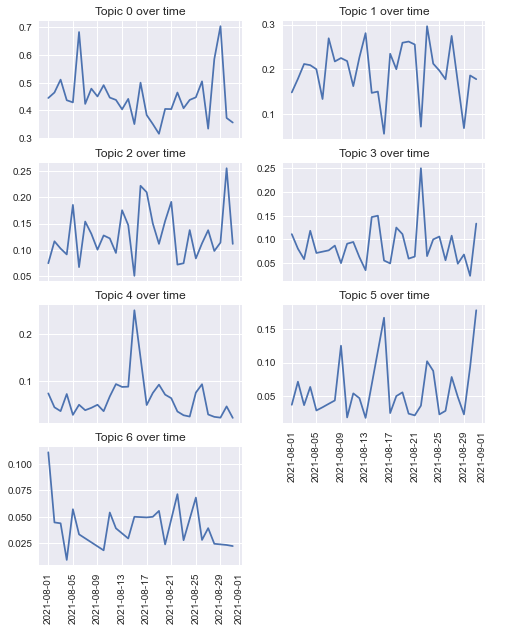

In [44]:
#show the development of tweet frequency of topics over time for the tweets in august
df_august_topic0 = df_august.loc[df_august['topic'] == 0]
df_august_topic1 = df_august.loc[df_august['topic'] == 1]
df_august_topic2 = df_august.loc[df_august['topic'] == 2]
df_august_topic3 = df_august.loc[df_august['topic'] == 3]
df_august_topic4 = df_august.loc[df_august['topic'] == 4]
df_august_topic5 = df_august.loc[df_august['topic'] == 5]
df_august_topic6 = df_august.loc[df_august['topic'] == 6]
df_august_freqs = pd.DataFrame(pd.to_datetime(df_august['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = pd.DataFrame(pd.to_datetime(df_august_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = df_august_topic0.merge(df_august_freqs, on ='index')
df_august_topic0['count'] = df_august_topic0['new_date_x']/df_august_topic0['new_date_y'] 
df_august_topic1 = pd.DataFrame(pd.to_datetime(df_august_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic1 = df_august_topic1.merge(df_august_freqs, on ='index')
df_august_topic1['count'] = df_august_topic1['new_date_x']/df_august_topic1['new_date_y'] 
df_august_topic2 = pd.DataFrame(pd.to_datetime(df_august_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic2 = df_august_topic2.merge(df_august_freqs, on ='index')
df_august_topic2['count'] = df_august_topic2['new_date_x']/df_august_topic2['new_date_y'] 
df_august_topic3 = pd.DataFrame(pd.to_datetime(df_august_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic3 = df_august_topic3.merge(df_august_freqs, on ='index')
df_august_topic3['count'] = df_august_topic3['new_date_x']/df_august_topic3['new_date_y'] 
df_august_topic4 = pd.DataFrame(pd.to_datetime(df_august_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic4 = df_august_topic4.merge(df_august_freqs, on ='index')
df_august_topic4['count'] = df_august_topic4['new_date_x']/df_august_topic4['new_date_y'] 
df_august_topic5 = pd.DataFrame(pd.to_datetime(df_august_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic5 = df_august_topic5.merge(df_august_freqs, on ='index')
df_august_topic5['count'] = df_august_topic5['new_date_x']/df_august_topic5['new_date_y']
df_august_topic6 = pd.DataFrame(pd.to_datetime(df_august_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic6 = df_august_topic6.merge(df_august_freqs, on ='index')
df_august_topic6['count'] = df_august_topic6['new_date_x']/df_august_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_august_topic0['index'], df_august_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_august_topic1['index'], df_august_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_august_topic2['index'], df_august_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_august_topic3['index'], df_august_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_august_topic4['index'], df_august_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_august_topic5['index'], df_august_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_august_topic6['index'], df_august_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

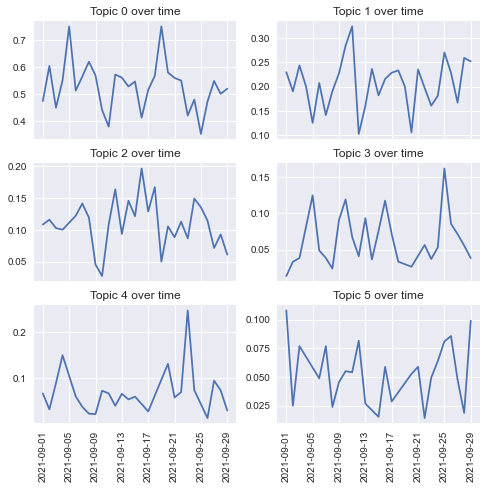

In [45]:
#show the development of tweet frequency of topics over time for the tweets in august
df_september_topic0 = df_september.loc[df_september['topic'] == 0]
df_september_topic1 = df_september.loc[df_september['topic'] == 1]
df_september_topic2 = df_september.loc[df_september['topic'] == 2]
df_september_topic3 = df_september.loc[df_september['topic'] == 3]
df_september_topic4 = df_september.loc[df_september['topic'] == 4]
df_september_topic5 = df_september.loc[df_september['topic'] == 5]
df_september_freqs = pd.DataFrame(pd.to_datetime(df_september['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = pd.DataFrame(pd.to_datetime(df_september_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = df_september_topic0.merge(df_september_freqs, on ='index')
df_september_topic0['count'] = df_september_topic0['new_date_x']/df_september_topic0['new_date_y'] 
df_september_topic1 = pd.DataFrame(pd.to_datetime(df_september_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic1 = df_september_topic1.merge(df_september_freqs, on ='index')
df_september_topic1['count'] = df_september_topic1['new_date_x']/df_september_topic1['new_date_y'] 
df_september_topic2 = pd.DataFrame(pd.to_datetime(df_september_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic2 = df_september_topic2.merge(df_september_freqs, on ='index')
df_september_topic2['count'] = df_september_topic2['new_date_x']/df_september_topic2['new_date_y'] 
df_september_topic3 = pd.DataFrame(pd.to_datetime(df_september_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic3 = df_september_topic3.merge(df_september_freqs, on ='index')
df_september_topic3['count'] = df_september_topic3['new_date_x']/df_september_topic3['new_date_y'] 
df_september_topic4 = pd.DataFrame(pd.to_datetime(df_september_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic4 = df_september_topic4.merge(df_september_freqs, on ='index')
df_september_topic4['count'] = df_september_topic4['new_date_x']/df_september_topic4['new_date_y'] 
df_september_topic5 = pd.DataFrame(pd.to_datetime(df_september_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic5 = df_september_topic5.merge(df_september_freqs, on ='index')
df_september_topic5['count'] = df_september_topic5['new_date_x']/df_september_topic5['new_date_y']
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_september_topic0['index'], df_september_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_september_topic1['index'], df_september_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_september_topic2['index'], df_september_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_september_topic3['index'], df_september_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_september_topic4['index'], df_september_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_september_topic5['index'], df_september_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

## Proportion of topics within user groups

In [46]:
#identify different user groups for whole data set
df_pos = df.loc[df['user.group'] == "Postdoc"]
df_prom = df.loc[df['user.group'] == "Promovierende"]
df_stu = df.loc[df['user.group'] == "Student"]
df_prof = df.loc[df['user.group'] == "Prof"]
df_med = df.loc[df['user.group'] == "Media"]
df_pol = df.loc[df['user.group'] == "Political rep"]
df_uni = df.loc[df['user.group'] == "Union rep"]
df_ins = df.loc[df['user.group'] == "Institution"]
df_bot = df.loc[df['user.group'] == "Bot"]
df_jun = df.loc[df['user.group'] == "Jun. prof"]
df_tea = df.loc[df['user.group'] == "Teacher"]
df_medic = df.loc[df['user.group'] == "Medical doctor"]
df_ac = df.loc[df['user.group'] == "Academic unspecified"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
df_ac_count = pd.DataFrame(df_ac['topic'].value_counts())
df_ac_count['topic'] = df_ac_count['topic']/len(df_ac)
print('ac')
print(df_ac_count)
print('post')
print(df_pos_count)
print('prom')
print(df_prom_count)
print('student')
print(df_stu_count)
print('prof')
print(df_prof_count)
print('meida')
print(df_med_count)
print('pol')
print(df_pol_count)
print('union')
print(df_uni_count)
print('inst')
print(df_ins_count)

ac
      topic
0  0.582340
1  0.179848
2  0.130823
4  0.043608
3  0.034128
5  0.029252
post
      topic
0  0.557210
2  0.168180
1  0.164911
4  0.042499
3  0.036687
5  0.030512
prom
      topic
0  0.506805
1  0.203363
2  0.164131
4  0.046437
3  0.041633
5  0.037630
student
      topic
0  0.651452
1  0.165975
2  0.112033
4  0.033195
3  0.020747
5  0.016598
prof
      topic
0  0.573279
2  0.169231
1  0.157895
4  0.041296
3  0.033198
5  0.025101
meida
      topic
0  0.633416
1  0.192020
3  0.089776
4  0.052369
2  0.019950
5  0.012469
pol
      topic
0  0.737589
1  0.156028
4  0.049645
3  0.028369
5  0.021277
2  0.007092
union
      topic
0  0.817308
2  0.067308
5  0.054487
1  0.044872
3  0.012821
4  0.003205
inst
      topic
0  0.698113
1  0.135849
2  0.064151
3  0.045283
4  0.033962
5  0.022642


In [47]:
#identify different user groups for german data set
df_pos = df_ger.loc[df_ger['user.group'] == "Postdoc"]
df_prom = df_ger.loc[df_ger['user.group'] == "Promovierende"]
df_stu = df_ger.loc[df_ger['user.group'] == "Student"]
df_prof = df_ger.loc[df_ger['user.group'] == "Prof"]
df_med = df_ger.loc[df_ger['user.group'] == "Media"]
df_pol = df_ger.loc[df_ger['user.group'] == "Political rep"]
df_uni = df_ger.loc[df_ger['user.group'] == "Union rep"]
df_ins = df_ger.loc[df_ger['user.group'] == "Institution"]
df_bot = df_ger.loc[df_ger['user.group'] == "Bot"]
df_jun = df_ger.loc[df_ger['user.group'] == "Jun. prof"]
df_tea = df_ger.loc[df_ger['user.group'] == "Teacher"]
df_medic = df_ger.loc[df_ger['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.137862
6  0.135871
2  0.135207
1  0.131888
7  0.121930
4  0.116176
3  0.115291
5  0.105776
      topic
6  0.136364
1  0.134429
0  0.134429
4  0.130561
5  0.127660
7  0.123791
2  0.114120
3  0.098646
      topic
2  0.174528
0  0.150943
6  0.150943
7  0.136792
3  0.122642
1  0.099057
4  0.084906
5  0.080189
      topic
6  0.188119
2  0.138614
7  0.125743
0  0.121782
3  0.112871
5  0.106931
1  0.106931
4  0.099010
      topic
6  0.164524
2  0.156812
3  0.151671
5  0.118252
0  0.115681
1  0.102828
4  0.102828
7  0.087404
      topic
6  0.226950
0  0.184397
2  0.134752
7  0.113475
1  0.113475
5  0.099291
4  0.063830
3  0.063830
      topic
2  0.387960
7  0.183946
1  0.163880
0  0.070234
6  0.070234
3  0.050167
5  0.043478
4  0.030100
      topic
2  0.211382
0  0.174797
1  0.121951
6  0.109756
5  0.105691
3  0.097561
7  0.093496
4  0.085366
      topic
0  0.232143
4  0.232143
7  0.125000
5  0.107143
1  0.089286
6  0.089286
2  0.071429
3  0.053571
      topic
3  0.185185
0  0

In [48]:
#identify different user groups for english data set
df_pos = df_en.loc[df_en['user.group'] == "Postdoc"]
df_prom = df_en.loc[df_en['user.group'] == "Promovierende"]
df_stu = df_en.loc[df_en['user.group'] == "Student"]
df_prof = df_en.loc[df_en['user.group'] == "Prof"]
df_med = df_en.loc[df_en['user.group'] == "Media"]
df_pol = df_en.loc[df_en['user.group'] == "Political rep"]
df_uni = df_en.loc[df_en['user.group'] == "Union rep"]
df_ins = df_en.loc[df_en['user.group'] == "Institution"]
df_bot = df_en.loc[df_en['user.group'] == "Bot"]
df_jun = df_en.loc[df_en['user.group'] == "Jun. prof"]
df_tea = df_en.loc[df_en['user.group'] == "Teacher"]
df_medic = df_en.loc[df_en['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
1  0.163121
0  0.159068
4  0.156028
2  0.155015
3  0.142857
5  0.137791
6  0.086120
      topic
0  0.227907
4  0.167442
2  0.148837
3  0.148837
1  0.130233
5  0.116279
6  0.060465
      topic
5  0.241379
4  0.172414
0  0.137931
6  0.137931
1  0.137931
2  0.103448
3  0.068966
      topic
0  0.200000
3  0.200000
5  0.168889
1  0.128889
4  0.115556
6  0.102222
2  0.084444
      topic
2  0.333333
0  0.250000
1  0.166667
5  0.083333
3  0.083333
4  0.083333
Empty DataFrame
Columns: [topic]
Index: []
      topic
6  0.307692
1  0.230769
2  0.153846
4  0.153846
3  0.076923
0  0.076923
      topic
1  0.210526
2  0.157895
0  0.157895
6  0.157895
3  0.157895
4  0.105263
5  0.052632
   topic
5   0.75
1   0.25
      topic
2  0.222222
3  0.222222
0  0.222222
5  0.111111
6  0.111111
1  0.111111
      topic
3  0.666667
0  0.333333
Empty DataFrame
Columns: [topic]
Index: []


In [49]:
#identify different user groups for June
df_pos = df_june.loc[df_june['user.group'] == "Postdoc"]
df_prom = df_june.loc[df_june['user.group'] == "Promovierende"]
df_stu = df_june.loc[df_june['user.group'] == "Student"]
df_prof = df_june.loc[df_june['user.group'] == "Prof"]
df_med = df_june.loc[df_june['user.group'] == "Media"]
df_pol = df_june.loc[df_june['user.group'] == "Political rep"]
df_uni = df_june.loc[df_june['user.group'] == "Union rep"]
df_ins = df_june.loc[df_june['user.group'] == "Institution"]
df_bot = df_june.loc[df_june['user.group'] == "Bot"]
df_jun = df_june.loc[df_june['user.group'] == "Jun. prof"]
df_tea = df_june.loc[df_june['user.group'] == "Teacher"]
df_medic = df_june.loc[df_june['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.400745
1  0.289295
2  0.137534
3  0.066734
5  0.044377
4  0.042005
6  0.019309
      topic
0  0.455182
1  0.210084
2  0.162465
3  0.065826
5  0.042017
4  0.037815
6  0.026611
      topic
0  0.466216
1  0.270270
3  0.087838
2  0.081081
4  0.060811
6  0.020270
5  0.013514
      topic
0  0.342308
1  0.261538
2  0.166667
5  0.093590
3  0.070513
4  0.038462
6  0.026923
      topic
0  0.433198
1  0.307692
3  0.076923
5  0.064777
2  0.044534
6  0.040486
4  0.032389
      topic
0  0.364486
1  0.317757
3  0.140187
5  0.084112
6  0.056075
4  0.028037
2  0.009346
      topic
1  0.577982
0  0.201835
3  0.128440
2  0.045872
4  0.027523
5  0.018349
      topic
1  0.362069
0  0.336207
3  0.137931
5  0.068966
2  0.051724
4  0.034483
6  0.008621
      topic
3  0.384615
1  0.307692
0  0.192308
2  0.076923
6  0.038462
      topic
0  0.491228
1  0.192982
3  0.105263
2  0.105263
5  0.052632
4  0.035088
6  0.017544
      topic
0  0.666667
1  0.208333
3  0.041667
4  0.041667
5  0.041667
   t

In [50]:
#identify different user groups for July
df_pos = df_july.loc[df_july['user.group'] == "Postdoc"]
df_prom = df_july.loc[df_july['user.group'] == "Promovierende"]
df_stu = df_july.loc[df_july['user.group'] == "Student"]
df_prof = df_july.loc[df_july['user.group'] == "Prof"]
df_med = df_july.loc[df_july['user.group'] == "Media"]
df_pol = df_july.loc[df_july['user.group'] == "Political rep"]
df_uni = df_july.loc[df_july['user.group'] == "Union rep"]
df_ins = df_july.loc[df_july['user.group'] == "Institution"]
df_bot = df_july.loc[df_july['user.group'] == "Bot"]
df_jun = df_july.loc[df_july['user.group'] == "Jun. prof"]
df_tea = df_july.loc[df_july['user.group'] == "Teacher"]
df_medic = df_july.loc[df_july['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.380851
1  0.266667
2  0.119149
5  0.071631
3  0.068794
4  0.049645
6  0.043262
      topic
0  0.444853
1  0.187500
2  0.161765
3  0.073529
4  0.058824
6  0.040441
5  0.033088
      topic
0  0.423729
2  0.203390
1  0.203390
4  0.084746
3  0.033898
5  0.033898
6  0.016949
      topic
0  0.445513
1  0.208333
2  0.157051
3  0.057692
4  0.054487
6  0.041667
5  0.035256
      topic
0  0.519481
2  0.233766
4  0.064935
3  0.064935
5  0.051948
1  0.038961
6  0.025974
      topic
0  0.714286
4  0.214286
1  0.071429
      topic
0  0.680556
1  0.111111
2  0.069444
4  0.055556
6  0.041667
5  0.027778
3  0.013889
      topic
0  0.466667
1  0.200000
2  0.160000
5  0.080000
3  0.040000
6  0.026667
4  0.026667
   topic
1    1.0
    topic
0  0.3125
3  0.1875
1  0.1875
6  0.1250
2  0.1250
4  0.0625
   topic
0   0.50
1   0.25
2   0.25
Empty DataFrame
Columns: [topic]
Index: []


In [51]:
#identify different user groups for August
df_pos = df_august.loc[df_august['user.group'] == "Postdoc"]
df_prom = df_august.loc[df_august['user.group'] == "Promovierende"]
df_stu = df_august.loc[df_august['user.group'] == "Student"]
df_prof = df_august.loc[df_august['user.group'] == "Prof"]
df_med = df_august.loc[df_august['user.group'] == "Media"]
df_pol = df_august.loc[df_august['user.group'] == "Political rep"]
df_uni = df_august.loc[df_august['user.group'] == "Union rep"]
df_ins = df_august.loc[df_august['user.group'] == "Institution"]
df_bot = df_august.loc[df_august['user.group'] == "Bot"]
df_jun = df_august.loc[df_august['user.group'] == "Jun. prof"]
df_tea = df_august.loc[df_august['user.group'] == "Teacher"]
df_medic = df_august.loc[df_august['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.447496
1  0.240711
2  0.121163
3  0.071082
5  0.043619
4  0.040388
6  0.035541
      topic
0  0.402878
1  0.215827
3  0.136691
2  0.093525
5  0.064748
4  0.064748
6  0.021583
      topic
0  0.571429
1  0.214286
3  0.142857
6  0.071429
      topic
0  0.434783
1  0.217391
5  0.108696
3  0.076087
4  0.065217
6  0.054348
2  0.043478
      topic
4  0.415094
0  0.169811
1  0.150943
3  0.113208
2  0.075472
5  0.037736
6  0.037736
      topic
2  0.363636
0  0.272727
4  0.181818
3  0.090909
1  0.090909
      topic
0  0.410714
2  0.232143
3  0.142857
5  0.089286
1  0.071429
4  0.035714
6  0.017857
      topic
0  0.500000
1  0.230769
3  0.115385
2  0.115385
5  0.038462
      topic
0  0.366667
2  0.300000
1  0.233333
6  0.033333
5  0.033333
4  0.033333
      topic
0  0.285714
2  0.285714
1  0.142857
5  0.142857
6  0.071429
3  0.071429
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [52]:
#identify different user groups for September
df_pos = df_september.loc[df_september['user.group'] == "Postdoc"]
df_prom = df_september.loc[df_september['user.group'] == "Promovierende"]
df_stu = df_september.loc[df_september['user.group'] == "Student"]
df_prof = df_september.loc[df_september['user.group'] == "Prof"]
df_med = df_september.loc[df_september['user.group'] == "Media"]
df_pol = df_september.loc[df_september['user.group'] == "Political rep"]
df_uni = df_september.loc[df_september['user.group'] == "Union rep"]
df_ins = df_september.loc[df_september['user.group'] == "Institution"]
df_bot = df_september.loc[df_september['user.group'] == "Bot"]
df_jun = df_september.loc[df_september['user.group'] == "Jun. prof"]
df_tea = df_september.loc[df_september['user.group'] == "Teacher"]
df_medic = df_september.loc[df_september['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.481905
1  0.241905
2  0.106667
3  0.064762
5  0.057143
4  0.047619
      topic
0  0.516129
1  0.217742
3  0.088710
5  0.080645
2  0.048387
4  0.048387
   topic
0   0.30
1   0.25
2   0.15
5   0.15
3   0.10
4   0.05
      topic
0  0.549020
1  0.196078
2  0.137255
3  0.058824
5  0.039216
4  0.019608
      topic
0  0.750000
2  0.125000
1  0.083333
5  0.041667
      topic
0  0.666667
1  0.111111
4  0.111111
2  0.111111
      topic
0  0.320000
1  0.213333
2  0.213333
4  0.160000
5  0.066667
3  0.026667
      topic
0  0.500000
2  0.145833
4  0.125000
1  0.125000
5  0.062500
3  0.041667
      topic
0  0.666667
1  0.333333
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []
